In [350]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
import math
import squarify
from datetime import date
import datetime
from functools import reduce
import warnings
import random
import re
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from collections import Counter
import matplotlib.pyplot as plt; plt.rcdefaults()
warnings.filterwarnings("ignore")

In [351]:
personal_data = pd.read_csv('./data/personal_train.csv')
personal_data = personal_data.drop(['Unnamed: 0'],axis=1)
other_data = pd.read_csv('./data/other_train.csv')
other_data = other_data.drop(['Unnamed: 0'],axis=1)

Zlúčenie dvoch datasetov do jedného, na základe stĺpcov, alebo stĺpca (v parametroch)

In [352]:

class MergeTransformer(TransformerMixin):
    def __init__(self,df1,df2,cols):
        self.df1 = df1
        self.df2 = df2
        self.cols = cols
    
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        df = pd.merge(self.df1,self.df2,on=self.cols)
        return df

Najprv sa uložia všetky duplikáty z DF, v pôvodnom sa vymažú, a následne sa vytvorí 1 unikátny záznam z množiny duplikátov, ktorý sa uloží na pôvodný dataset. Ak má stĺpec: spojité hodnoty, tak sa vyráta priemer. Ak má diskrétne, tak sa priradí náhodne, ak má samé NaN alebo ?, tak NaN.

In [353]:
class DeduplicationTransformer(TransformerMixin):
    def __init__(self,cols,groupBy):
        self.cols = cols
        self.groupBy = groupBy
    
    def _checkNaN(self,arr):
        for item in arr:
            if((type(item) is not np.float64 and type(item) is not float) or not np.isnan(item)):
                return False
        return True
    def _checkQuestionMark(self,arr):
        for item in arr:
            if(item is not '?'):
                return False
        return True
    def _nanOrQuestionMark(self,arr):
        for item in arr:
            if(item is not '?' and ((type(item) is not np.float64 and type(item) is not float) or not np.isnan(item))):
                return False
        return True
    
    def _filter_nan_question_mark(self,arr):
        result = []
        for item in arr:
            if(item is not '?' and ((type(item) is not np.float64 and type(item) is not float) or not np.isnan(item))):
                result.append(item)
        return result 
    
    def _getUniqueRow(self,duplicates,startIndex,endIndex):
        row_dict = {}

        for column in duplicates.columns: 
            temp = []
            for index in range(startIndex,endIndex):
                temp.append(duplicates.iloc[index][column])
         
            if(self._checkNaN(temp)):
                row_dict[column] = np.nan
            elif(self._checkQuestionMark(temp)):
                row_dict[column] = np.nan
            elif(self._nanOrQuestionMark(temp)):
                row_dict[column] = np.nan
            else:
                temp = self._filter_nan_question_mark(temp)
                if(np.array(temp).dtype == 'float64'):
                    row_dict[column] = np.mean(temp)
                else:
                    value = randint(0,len(temp)-1)
                    row_dict[column] = temp[value]
        return row_dict

    def fit(self,df,y=None):
        return self
    
    def transform(self,df,y=None):
        duplicated = df.duplicated(subset=self.cols,keep=False)
        duplicates = pd.DataFrame(columns=df.columns)
        indexes_to_drop = []
        df_without_duplicates = pd.DataFrame(columns=df.columns)
        for index, row in df.iterrows():
            if(duplicated[index]):
                duplicates = duplicates.append(df.iloc[index],ignore_index=True)
                indexes_to_drop.append(index)

        duplicates.sort_values(self.cols)
        df_without_duplicates = df
        for index in indexes_to_drop:
            df_without_duplicates = df_without_duplicates.drop(df.index[index])

        df = df_without_duplicates
        count = 0
        lastDuplicate = duplicates.iloc[0][self.groupBy]
        columns = duplicates.columns.values
        for index,row in duplicates.iterrows():
            entry = duplicates.iloc[index]
            name = entry[self.groupBy]
            if(name == lastDuplicate):
                count += 1
            else:
                df = df.append(self._getUniqueRow(duplicates,index-count,index),ignore_index=True)
                lastDuplicate = name
                count = 1
        
            if(len(duplicates) - 1 == index):
                df = df.append(self._getUniqueRow(duplicates,index-count+1,index + 1),ignore_index=True)
        
        return df

Zadáme nežiaduce znaky ako parametre, a následne preiterujeme všetky údaje, a pokiaľ narazíme na daný nežiaduci znak, tak mu priradíme NaN.

In [354]:
class ToNaNTransformer(TransformerMixin):
    def __init__(self,signs):
        self.signs = signs
    
    def _checkSign(self,x):
        for sign in self.signs:
            if sign == str(x).strip(" "):
                return True
        return False
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        for column in df.columns:
            df[column] = df[column].map(lambda x: np.nan if self._checkSign(x) else x)
        return df

Pokiaľ máme stĺpec, ktorý obsahuje objekty, tak ho rozložíme na viacero stĺpcov. Pôvodný stĺpec nevymazávame, pretože ho možno ešte budeme potrebovať.

In [355]:
class ObjectValuesTransformer(TransformerMixin):
    def __init__(self,columns):
        self.cols = columns
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        for index, row in df.iterrows():
            for column in self.cols:
                if(str(row[column]) != 'nan'):
                    newRow = eval(str(row[column]))
                    for key, value in newRow.items():
                        df.loc[index,key] = value
        return df

Na zvolených stĺpcoch vyráta priemernú hodnotu, a doplní do NaN hodnôt.

In [356]:
class MeanTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        self.col_means = {}
        
    def fit(self,df, y=None):
        
        for column in self.columns:
            df[column] = df[column].map(lambda x: float(x))
            self.col_means[column] = math.floor(np.nanmean(df[column].tolist()))
        return self
    
    def transform(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].map(lambda x: self.col_means[column] if str(x).lower() == 'nan' else float(x))
        return df


Sformátovanie rôznych formátov dátumov na jednotný formát.

In [357]:
class FormatDateTransformer(TransformerMixin):
    def __init__(self,column):
        self.column = column
    def _format_date(self,string):
        for fmt in ["%Y/%m/%d", "%Y%m%d", "%y-%m-%d", "%Y-%m-%d", "%Y-%m-%d %H:%M:%S", "%Y-%m-%d %H %M %S", "%d/%m/%Y"]:
            try:
                return datetime.datetime.strptime(string, fmt).date()
            except ValueError:
                continue
        raise ValueError(string)
        
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        df[self.column] = df[self.column].map(lambda x: self._format_date(x) if type(x) is str else x)
        return df
    

Táto funkcia vyráta priemerný dátum pre NaN hodnotu, spomedzi všetkých dátumov.

In [358]:
class MeanDateTransformer(TransformerMixin):
    def __init__(self,age_column,date_column):
        self.age_column = age_column
        self.date_column = date_column
        self.mean_age = 0;
        self.mean_date = 0;
        
    def fit(self,df,y=None):
        self.mean_age = np.nanmean(df[self.age_column].tolist())
        self.mean_date = datetime.datetime(math.floor(datetime.datetime.now().year - self.mean_age), datetime.datetime.now().month, datetime.datetime.now().day,
                           datetime.datetime.now().hour, datetime.datetime.now().minute).date()
        return self
    def transform(self,df,y=None):
        df[self.date_column] = df[self.date_column].map(lambda x: self.mean_date if str(x) == 'nan' else x)
        i = 0
        for date in df[self.date_column]:
            if(date > datetime.datetime.now().date()):
                modifiedDate = datetime.datetime(datetime.datetime.now().year-int(df[self.age_column][i]), date.month, date.day).date()
                df[self.date_column][i] = modifiedDate 
            i += 1
        return df

Pre daný stĺpec, ktorý ma obsahovať len T a F hodnoty (no obsahuje aj nežiaduce hodnoty ako False,FALSE,F.15) urobíme algoritmus, ktorý zjednotí všetky hodnoty len na prislúchajúce T a F.

In [359]:
class TrueFalseTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    def _mapTrueFalse(self,x):
        if("t" in str(x).lower()):
            return "t"
        elif("f" in str(x).lower()):
            return "f"
        else:
            return np.nan
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].map(lambda x: self._mapTrueFalse(x))
        return df

Algoritmus vyráta pre stĺpec medián, a doplní ho do NaN riadkov.

In [360]:
class MedianTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        self.cols_median = {}
        
    def fit(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].map(lambda x: float(x))
            self.cols_median[column] = np.nanmedian(df[column].tolist())
        return self
    
    def transform(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].map(lambda x: self.cols_median[column] if str(x).lower() == 'nan' else x)
        return df

Táto funkcia doplní do NaN riadkov určitú hodnotu. Táto hodnota sa vyráta nasledovne: Zistíme pomer všetkých hodnôt, a náhodne sa na základe toho vyberie hodnota, ktorá sa vloží do NaN riadku

In [361]:
class CategoricalTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        self.cols_value_to_fill = {}
    def fit(self,df,y=None):
        for column in self.columns:
            self.cols_value_to_fill[column] = pd.Series(np.random.choice(self._getUniqueValues(df[column]),p=self._getRatio(df[column]),size=len(df[column])))
        return self
    
    def _getUniqueValues(self,arr):
        return arr.value_counts(normalize=True, dropna=True).index

    def _getRatio(self,arr):
        return arr.value_counts(normalize=True, dropna=True).values
    def transform(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].fillna(self.cols_value_to_fill[column])
        return df

Ako parametrom je pole objektov, ktorý sa zkladá z: 1.stĺpec, 2. znak z ktorého chceme meniť, 3.znak na ktorý chceme meniť. Čiže v určitom stĺpci zmeníme jeden znak na druhý. Taktiež v tejto funkcií dáme všetky znaky na malé písmená.

In [362]:
class ReplacerTransformer(TransformerMixin):
    def __init__(self,replace_info_arr):
        self.all_info = []
        for replace_info in replace_info_arr:
            self.all_info.append(replace_info)
        
    def fit(self,df,y=None):
        return self
    
    def transform(self,df,y=None):
        for info in self.all_info:
            df[info["column"]] = df[info["column"]].map(lambda x: x.lower().replace(info["current"],info["new"]))
        return df

Do NaN hodnôt sa dosadí hodnota. Táto hodnota je vyrátaná ako: Zoberieme S

In [363]:
class KnearestTransformer(TransformerMixin):
    def __init__(self,columns,k=3):
        self.columns = columns
        self.k_num = k
    
    def _kNearest(self,df,column,k=3):
        kNearest = []
        i = 0
        for item in df[column]:
            if(str(item) == 'nan'):
                kNearest = []
                for index in range(2*k+1):
                    if(i+k-index < len(df) and i+k-index > -1 and i+k-index != i and str(df[column][i+k-index]) != 'nan'):
                        kNearest.append(df[column][i+k-index])
                nearestAvg = reduce(lambda x, y: x + y, kNearest) / len(kNearest)
                df[column][i] = math.floor(nearestAvg)
            i += 1
        return df
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        for column in self.columns:
               df = self._kNearest(df,column,self.k_num)
        return df

Age je špecifický stĺpec, pre ktorý odstraňujeme vychýlené hodnoty. Keďže veku prislúcha aj dátum, tak pri hodnotách, ktoré zmeníme pri Age stĺpci, tak ich zmeníme aj pri dátume (tak, aby dátum narodenia sedel s vekom).

In [364]:
class OutleirsRemovalForAgeAndDateTransformer(TransformerMixin):
    
    def __init__(self,age_column,date_column,value):
        self.age_column = age_column
        self.date_column = date_column
        self.value = value
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        for index,row in df.iterrows():
            if(df[self.age_column][index] > self.value):
                df[self.age_column][index] = self.value
                df[self.date_column] = datetime.datetime(math.floor(datetime.datetime.now().year - self.value), df[self.date_column][index].month, df[self.date_column][index].day).date()
                
        return df

Na všetkych stĺpcoch, o ktorých predpokladáme, že majú byť číselné, vykonáme túto funkciu, ktorá z nich urobí floaty (aj keď predtým boli stringy, alebo objekty). 

In [365]:
class FormatToFloatTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].map(lambda x: float(x))
        return df

Nahradenie vychýlené hodnoty z float stĺpca. Výchýlená hodnota je hodnota menšia ako 5 percentil alebo väčšia ako 95 percentil. Pokiaľ je číslo menšie ako 5 percentil, nahradíme ju číslom, ktoré je rovné 5 percentilu, a ak je väčšie ako 95 percentil, nahradíme ju číslom, ktoré reprezentuje 95 percentil.

In [366]:
class OutleirsRemoval(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        self.outlayer_95 = {}
        self.outlayer_5 = {}
    def fit(self,df,y=None):
        for column in self.columns:
            self.outlayer_95[column] = np.nanpercentile(df[column],95)
            self.outlayer_5[column] = np.nanpercentile(df[column],5)
        return self
    def transform(self,df,y=None):
        for index,row in df.iterrows():
            for column in self.columns:
                if df[column][index] > self.outlayer_95[column]:
                    df[column][index] = self.outlayer_95[column]
                elif df[column][index] < self.outlayer_5[column]:
                    df[column][index] = self.outlayer_5[column]
        return df
            

In [367]:
true_false_columns = ["sick","T3 measured","query hypothyroid", "query hyperthyroid","FTI measured","lithium","TT4 measured", "pregnant",
                     "thyroid surgery","TBG measured","TSH measured","query on thyroxine","I131 treatment","on thyroxine","psych", "T4U measured", "tumor",
                    "goitre","hypopituitary","on antithyroid medication"]

categorical_columns = ["sick","query hypothyroid", "query hyperthyroid","FTI measured","lithium","TT4 measured", "pregnant",
                     "thyroid surgery","TSH measured","query on thyroxine","I131 treatment","on thyroxine","psych", "tumor",
                     "goitre","hypopituitary","on antithyroid medication","sex","workclass","native-country","occupation","T3 measured","T4U measured"]

replace_info = [
    {
        "column":"education",
        "current":"_",
        "new":"-"
    },
    {
        "column":"class",
        "current": ".|",
        "new":"|"
    }
]

pip_merge = Pipeline([
    ('merge',MergeTransformer(personal_data,other_data,["name","address"]))
])
pip = Pipeline([
    ('objectvalues',ObjectValuesTransformer(["medical_info"])),
    ('deduplicate',DeduplicationTransformer(["name","address"],"name")),
    ('nan',ToNaNTransformer(["?","nan"])),
    ('format-date',FormatDateTransformer("date_of_birth")),
    ('format-to-floats',FormatToFloatTransformer(["age","T4U","capital-loss","capital-gain","TSH","FTI","T3","education-num","TT4","hours-per-week","fnlwgt"])),
    ('date-outlayers',OutleirsRemovalForAgeAndDateTransformer("age","date_of_birth",110)),
    ('outlayers',OutleirsRemoval(["age","T4U","capital-loss","capital-gain","TSH","FTI","T3","education-num","TT4","hours-per-week","fnlwgt"])),
    ('mean',MeanTransformer(["age","T4U","capital-loss","TSH","FTI"])),
    ('median',MedianTransformer(["T3","education-num"])),
    ('knearest',KnearestTransformer(["TT4"])),
    ('date',MeanDateTransformer("age","date_of_birth")),
    ('true-false-mapping',TrueFalseTransformer(true_false_columns)),
    ('categorical',CategoricalTransformer(categorical_columns)),
    ('replacer',ReplacerTransformer(replace_info))
])
merged_before_transform = pd.DataFrame()
model = pip_merge.fit(merged_before_transform)
merged_before_transform = model.transform(merged_before_transform)
model = pip.fit(merged_before_transform)
merged = model.transform(merged_before_transform)

In [368]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 46 columns):
name                         2237 non-null object
address                      2237 non-null object
age                          2237 non-null float64
sex                          2237 non-null object
date_of_birth                2237 non-null object
query hyperthyroid           2237 non-null object
FTI measured                 2237 non-null object
education                    2237 non-null object
lithium                      2237 non-null object
TT4                          2237 non-null float64
T4U                          2237 non-null float64
capital-loss                 2237 non-null float64
capital-gain                 2237 non-null float64
tumor                        2237 non-null object
TSH                          2237 non-null float64
T3                           2237 non-null float64
fnlwgt                       2237 non-null float64
hours-per-week               2237 n

**Porovnanie veku pred a po**

Ako prvé, budeme demonštrovať to, ako sa nám podarilo vyčistiť dáta so stĺpcom ,,age". Keďže dáta potrebujeme mať validné, tak musíme zabezpečiť, aby boli všetky veky čísla (zbavenie sa NanN a ,,?"), väčšie ako 0, menšie ako 110 (tento vek sme rozhodli ako hraničný, a každý vyšší vek bude považovaný za nevalidný - je možné ho zmeniť v pipeline).

In [369]:
def ShowPieChart(data,when):
    ages = '0-110', 'else'
    hist = [0,0]
    y_pos = np.arange(len(ages))
    for item, frame in data.iteritems():
        if math.isnan(frame):
            hist[1] = hist[1] + 1
        if frame > 110:
            hist[1] = hist[1] + 1
        if frame > 0 and frame < 110:
            hist[0] = hist[0] + 1
        if frame < 0:
            hist[1] = hist[1] + 1    

    labels = ['0-110','else']
    sizes = [hist[0], hist[1]]
    colors = ['lightskyblue', 'lightcoral']

    plt.title(when)
    plt.pie(sizes, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=120)
    plt.legend(labels, loc="best")
    plt.axis('equal')
    plt.figure(0)
    plt.tight_layout()

Ako vidíme na koláčovom grafe, len malé percento záznamov bolo nevalidných (2 záznamy) a ostatných 2235 bolo validných. Vo funkcií ToNanTransformer je opísané, ako sme sa daných nevalidných údajov zbavili.

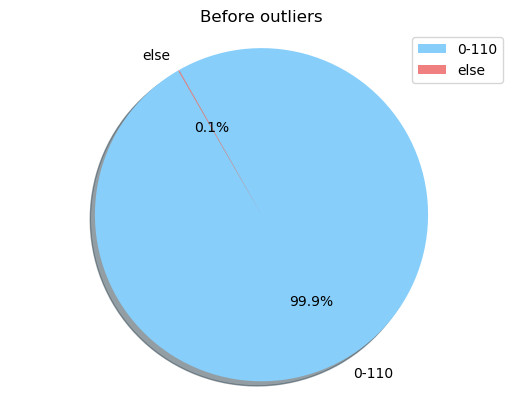

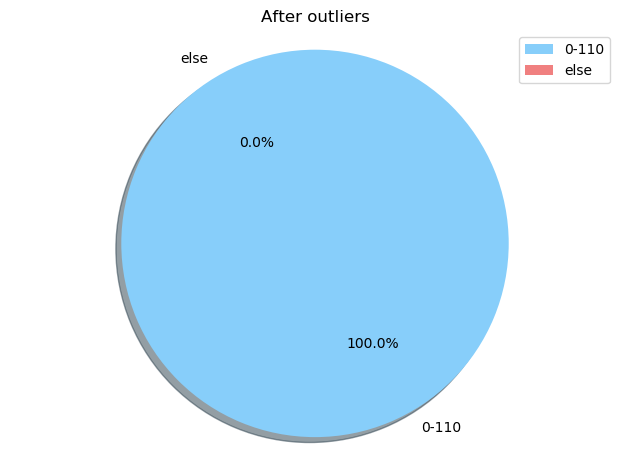

In [370]:
ShowPieChart(personal_data["age"], "Before outliers")

ShowPieChart(merged["age"],"After outliers")

plt.show()

**Vychylovanie hodnôt pred a po**

V nasledujúcom algoritme sa snažíme upraviť dáta tak, aby hodnoty presahujúce 95 percentil a hodnoty menšie ako 5 percentil boli odstránené. Odstraňovanie musí byť vykonané kvôli tomu, aby sme pri analýze a práce s údajmi neboli príliš vychýlený od priemerných hodnôt, a neboli tým naše pozorovania ovplyvnené. Algoritmus na odstraňovanie vychýlených hodnôt je opísaný vyššie vo funkcií OutlayersRemoval(). 

V grafoch demonštrujeme, ako sa nám hodnoty upravili po nahradení čísel X takých: ak F(x) je kvantil Qp, a p < 0.05 || p > 0.95 tak nahradíme danú hodnotu.

Graf reprezentuje stĺpec, ľavá hodnota ukazuje boxplot pred čistením, a napravo je už zmenený stĺpec po odstránení nežiaducich hodnôt. Ako môžeme vidieť, medián ani priemer sa nezmenil (o čo sme sa snažili, aby neprišlo k porušeniu dát).


In [371]:
def showBoxPlot(arr, name, row, column):    
    plt.subplot2grid(fig_dims, (row, column))
    plt.title('%s - distrubution' %name)
    objects = ('Before', 'After')
    plt.boxplot(arr)
    y_pos = np.arange(len(arr))
    plt.xticks(y_pos+1, objects)
    
def showBoxPlotForColumns(arrayOfColumns, df):
    rows = 0
    columns = 0
    for column in arrayOfColumns:
        beforeOutliers = df[column]
        beforeOutliers = beforeOutliers[~np.isnan(df[column])]
        
        data = [beforeOutliers,merged[column]]
        showBoxPlot(data, column, rows, columns)
        columns += 1
        if(columns > 2):
            rows += 1
            columns = 0

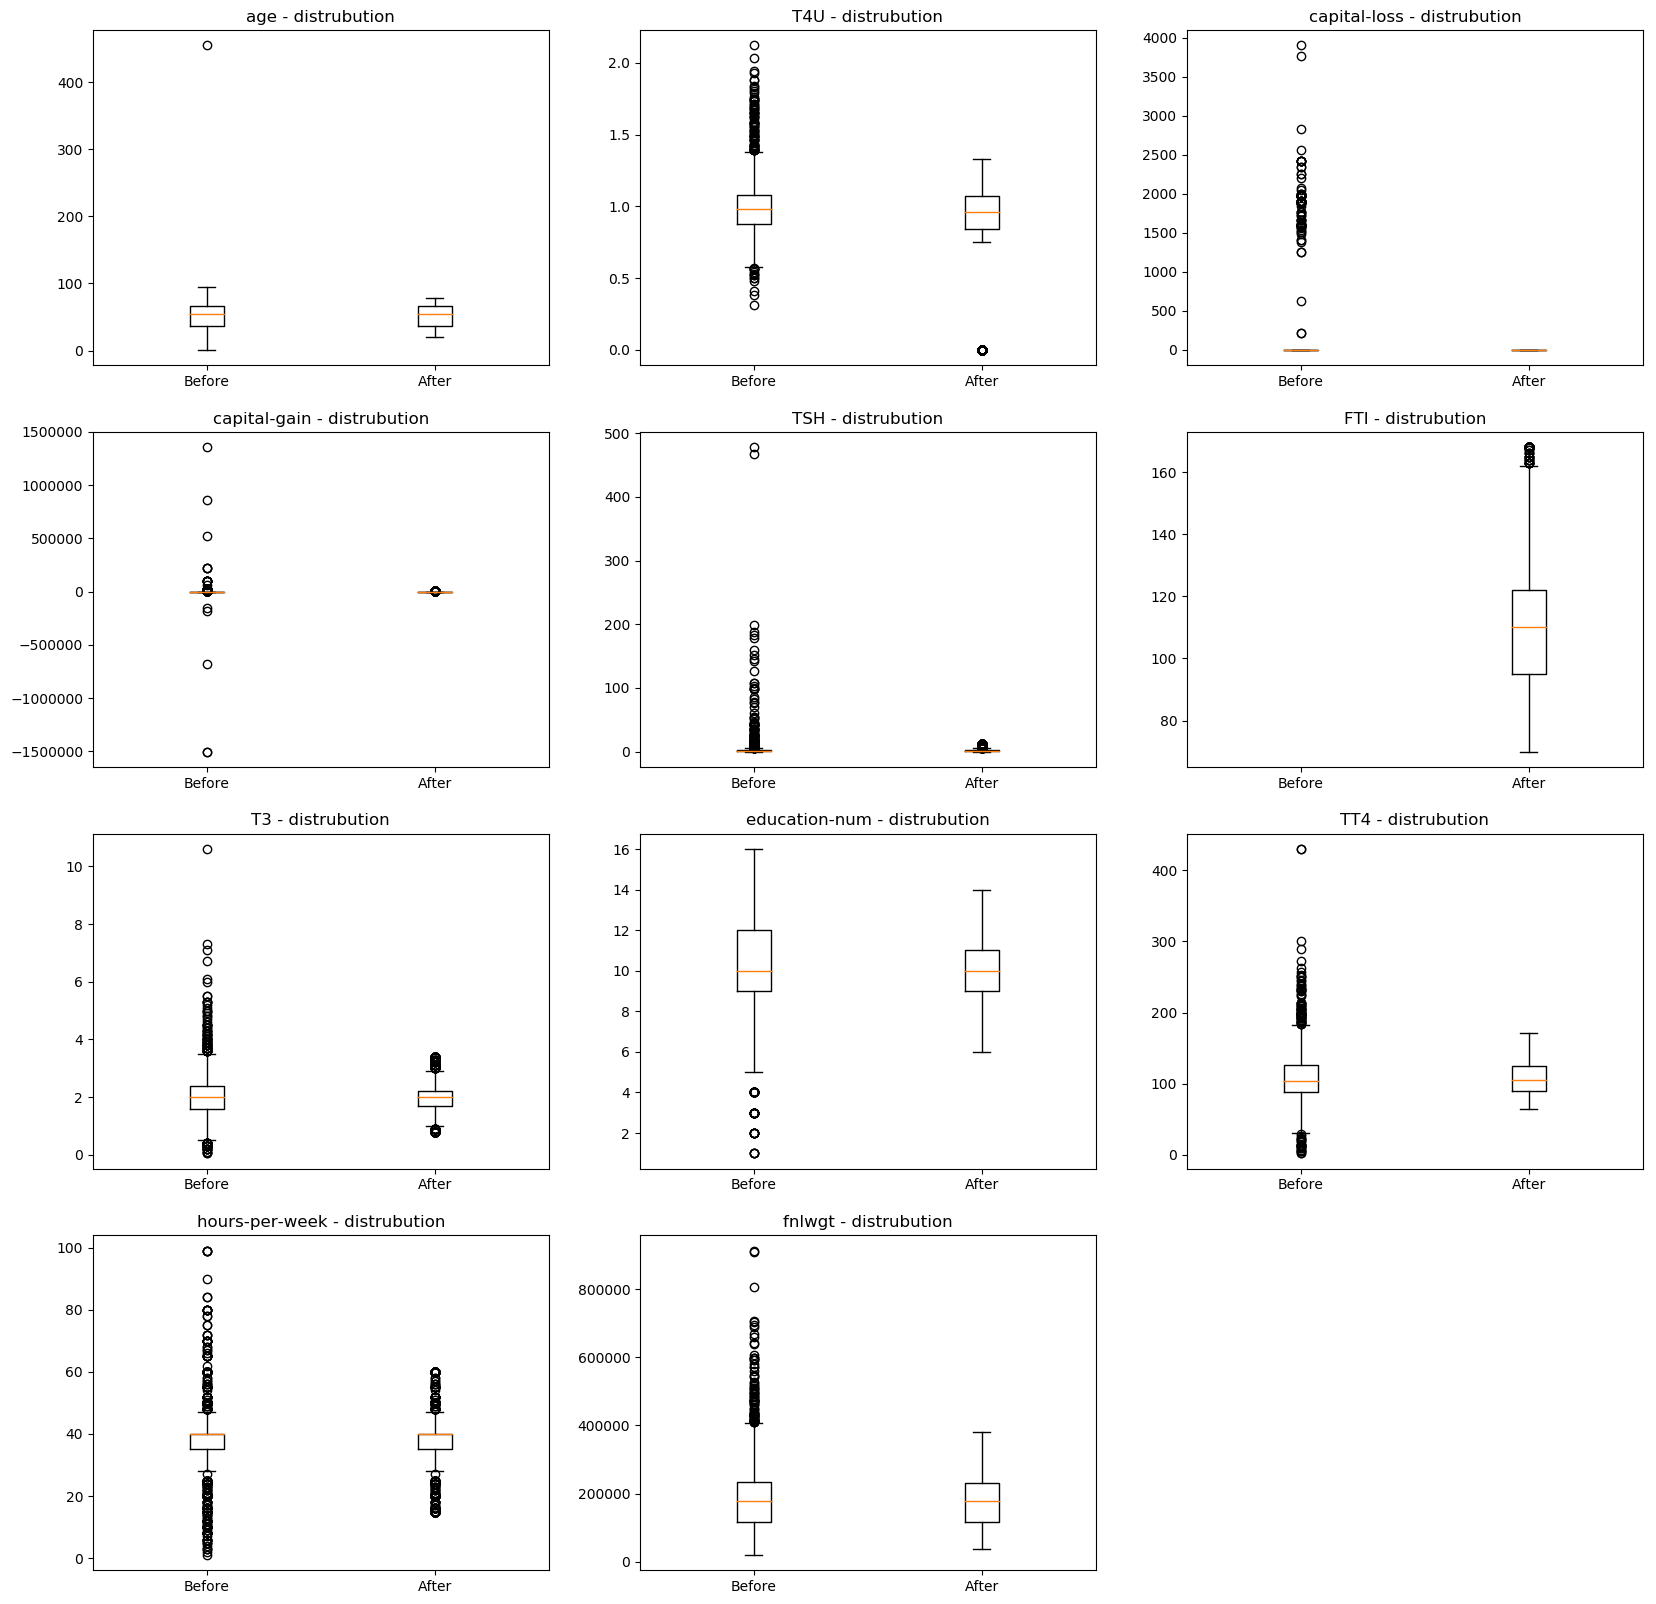

In [372]:
fizsize_with_subplots = (20, 20)
fig = plt.figure(figsize=fizsize_with_subplots) 
fig_dims = (4,3)
def toFloats(df,columns):
    for column in columns:
        df[column] = df[column].map(lambda x: np.nan if type(x) == str else float(x))
    return df
numColumns = ["age","T4U","capital-loss","capital-gain","TSH","FTI","T3","education-num","TT4","hours-per-week","fnlwgt"]
merged_before_transform = toFloats(merged_before_transform,numColumns)
showBoxPlotForColumns(numColumns,merged_before_transform)
plt.show()


**True/False stĺpce pred a po**

V nasledujúcom algoritme ukazujeme upravenie stĺpcov s NaN hodnotami. Keďže sa nám v stĺpcoch zobrazovali nežiaduce hodnoty ako f.2, t.16, NaN, alebo rozdielne pomenovania (False-FALSE-false), museli sme dané stĺpce upraviť. Algoritmus, ktorým čistíme tieto hodnoty je opísaný pri funkcií TrueFalseTransformer(). Horná rad grafov reprezentuje dáta pred čistením, a druhý rad reprezentuje už vyčistené dáta. Ako môžeme vidieť, všetky nežiadúce stĺpce boli nahradené/upravené validnými.

In [373]:
def TrueFalseGraph(data,index, description):
    data.value_counts().plot(ax=axs[index], kind='bar',title = description)

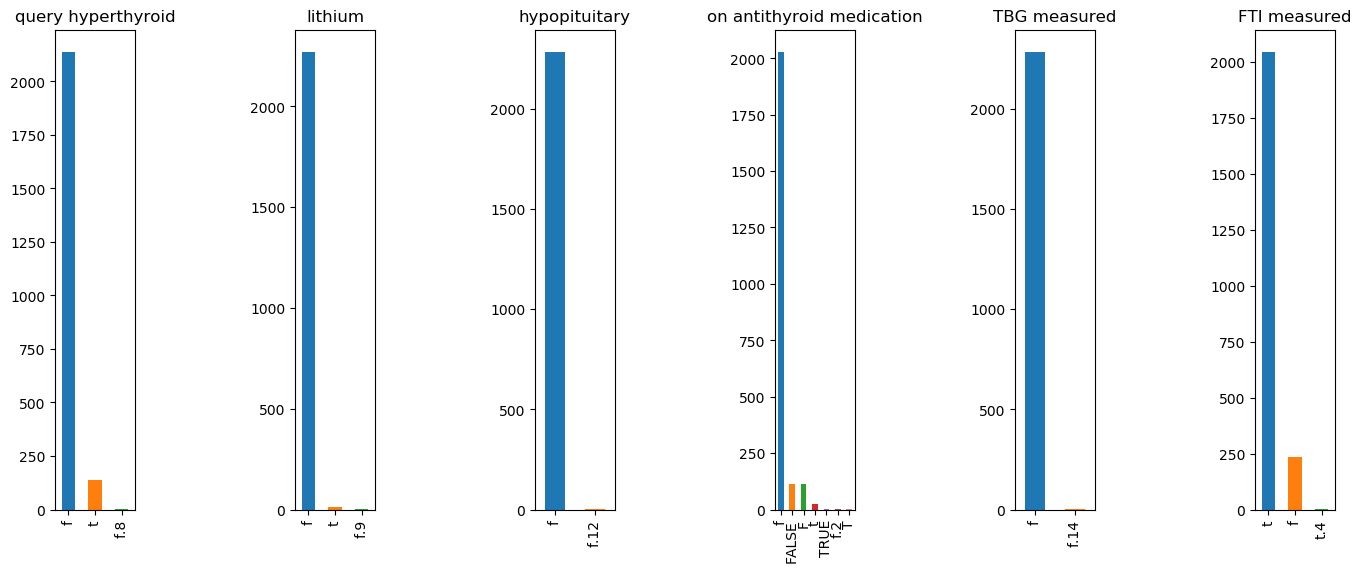

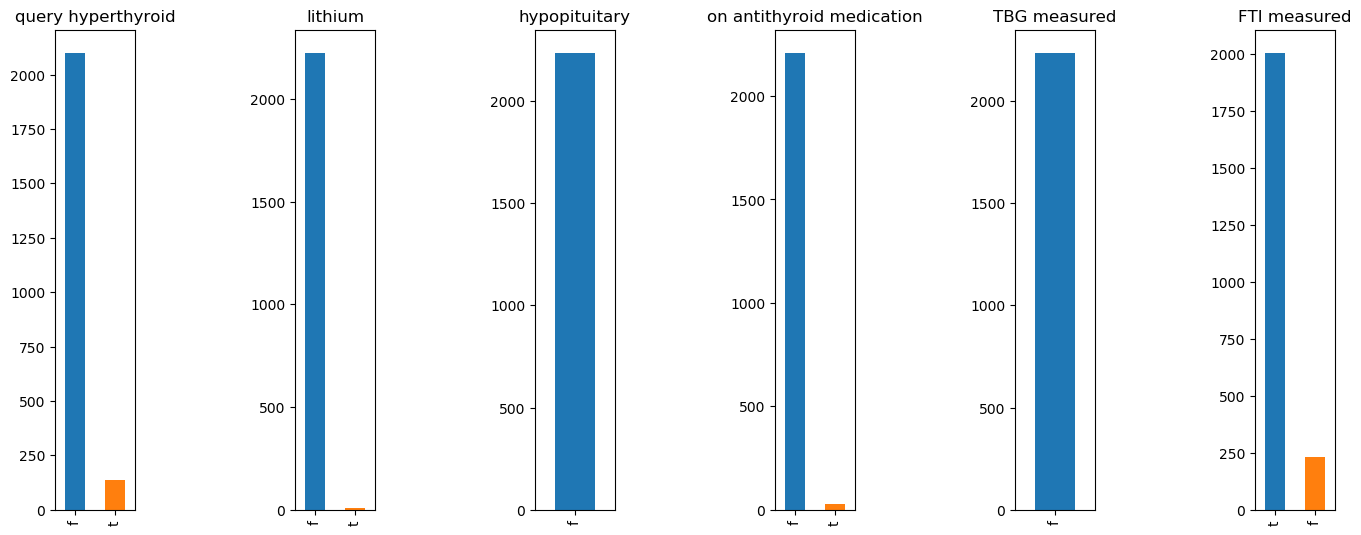

In [374]:
x =  [other_data, merged]

for ds in x:

    fig, axs = plt.subplots(1,6)
    arr = [ds['query hyperthyroid'],ds['lithium'], ds['hypopituitary'],ds['on antithyroid medication'],ds['TBG measured'],ds['FTI measured'] ]

    i = 0
    for col in arr:
        TrueFalseGraph(col,i,col.name)
        i = i + 1

    plt.subplots_adjust(left=4, bottom=3, right=6, top=4, wspace=2, hspace=1)
    plt.show()


**Kategorické stĺpce pred a po **

Keďže v analýze využívame aj stĺpce, ktoré nenadobúdajú spojité hodnoty, ale diskrétne, to znamená, že do nich nemôžme dať hodnotu, ktorá by sa tam nevyskytla /a jednak by sme potrebovali veľmi zložitý algoritmus na to, aby sme takéto niečo dokázali). Na grafe demonštruujeme úpravu dát, ktoré boli nekonzistentné. Za nekonistentné dáta môžeme považovať hodnoty s ,,?", NaN, alebo aj synonymá (8th-9th a 8th_9th).

Ako môžeme vidieť, prišlo k značnej redukcií typov (či už v stĺpci ,,education" alebo "workclass"). A tým pádom dostávame rozdielne histogramy výskytov daných typov.


In [375]:
def ShowHistogram(column, title,randColor ):
    x = [other_data,merged]

    iter = 0
    for ds in x:

        labels = set(ds[column])
        mynewlist = list(labels)

        mynewlist
        hist = []
        triangle = []
        for h in mynewlist:
            hist.append(0)
            triangle.append(0.10)

        i = 0    
        for educationType in mynewlist:
            for row in ds[column]:
                if row == educationType:
                    hist[i] = 1 + hist[i]

            i = i + 1    
        #newhist = mynewlist.map(lambda x: "unnamed" if str(x).lower() == 'nan' else x)
        resultsList = ["unnamed" if str(x).lower() == 'nan' else x for x in mynewlist]
        resultsHist = [0 if x == 0 else x for x in hist]
        y_pos = np.arange(len(resultsHist))
        plt.barh(y_pos, resultsHist, align='center',color=randColor, alpha=0.5)
        plt.yticks(y_pos, resultsList)
        if iter == 0:
            plt.title(title + " before")
        else:
            plt.title(title + " after")      
        plt.plot(figsize=(20,10))
        plt.show() 
        iter = iter + 1

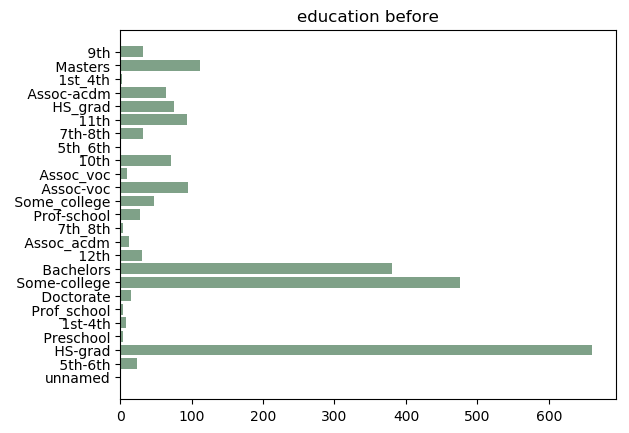

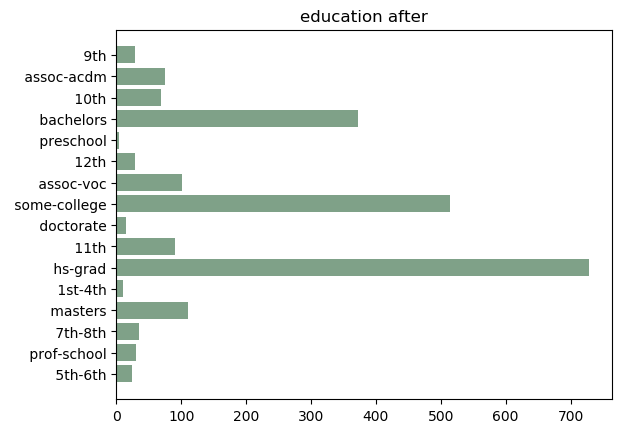

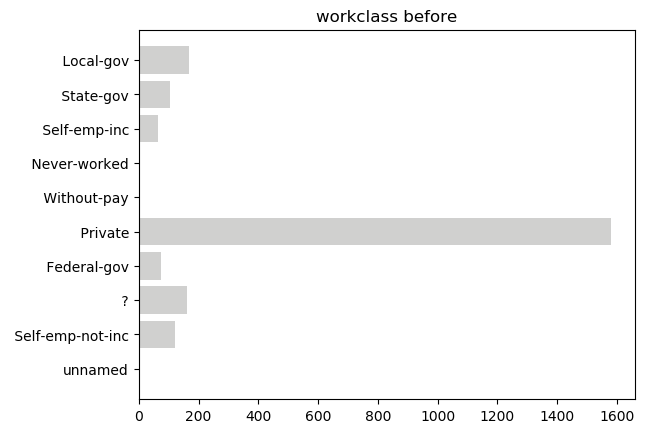

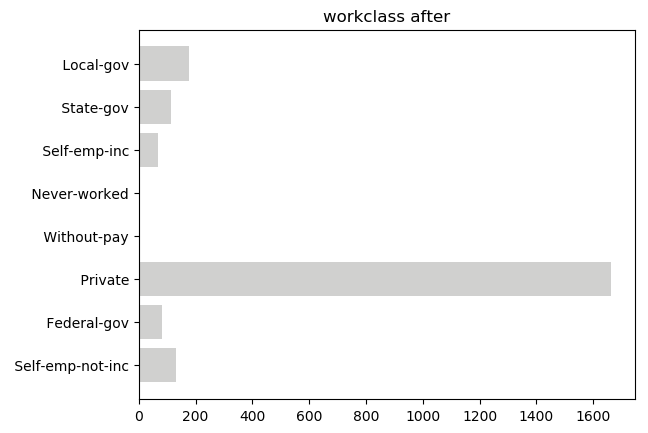

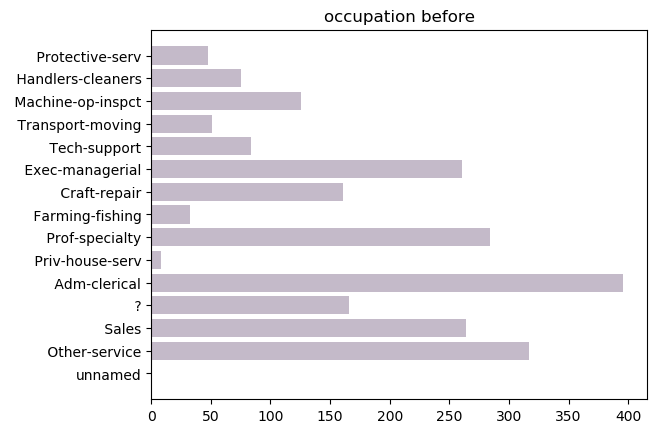

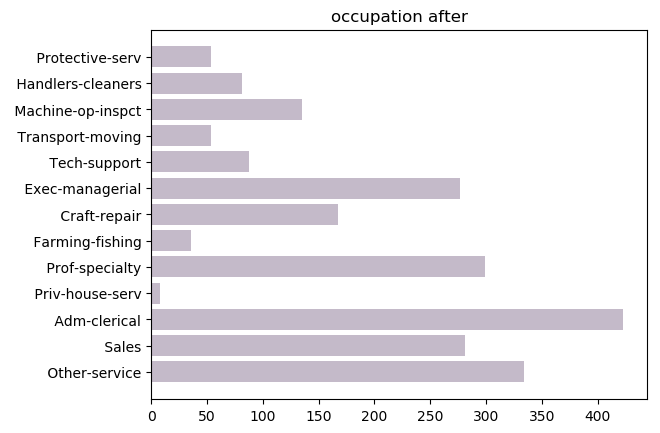

In [376]:
x = "education","workclass","occupation"
for col in x:
    randColor = (random.uniform(0, 0.7),random.uniform(0, 0.7),random.uniform(0, 0.7),0.5)
    if randColor[0] == 1 and randColor[1] == 1 and randColor[2] == 1:
        randColor = (1,0,0,0.5)
    ShowHistogram(col,col,randColor)


In [377]:
pip_to_compare = Pipeline([
    ('deduplicate',DeduplicationTransformer(["name","address"],"name")),
    ('nan',ToNaNTransformer(["?","nan"])),
    ('format-to-floats',FormatToFloatTransformer(["TT4"])),
    ('outlayers',OutleirsRemoval(["TT4"])),
    ('mean',MeanTransformer(["TT4"]))
])

model2 = pip_to_compare.fit(merged_before_transform)
method_comparison_df = pip_to_compare.transform(merged_before_transform)

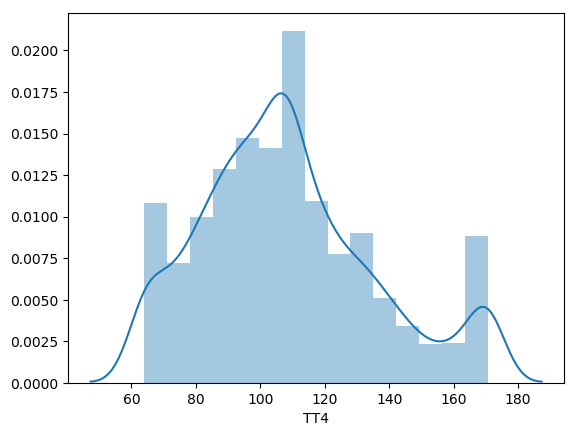

In [378]:

sns.distplot(method_comparison_df["TT4"],bins=15)
plt.show()

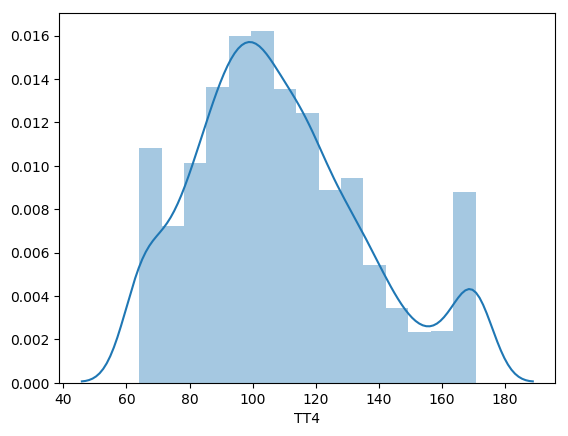

In [379]:
sns.distplot(merged["TT4"],bins=15)
plt.show()

**Formáty dátumov Pred a Po**

Na začiatku sa v stĺpci date_of_birth nachádzalo priveľa nekonzistentných údajov. Jednalo sa buď o nevalidné dátumy (rok narodenia 1440), alebo išlo o rôzne zápisy dátumov. V algoritme FormatDateTransformer() je opísané, akým štýlom sme dané dátumy upravovali. Na nasledujúcich 2 grafoch vidíme stav pred, kde sa nachádzalo viac ako 6 rôznych formátov, a následným algoritmom dostávame požadovaný výsledok - jeden formát dátumu pre všetky údaje.

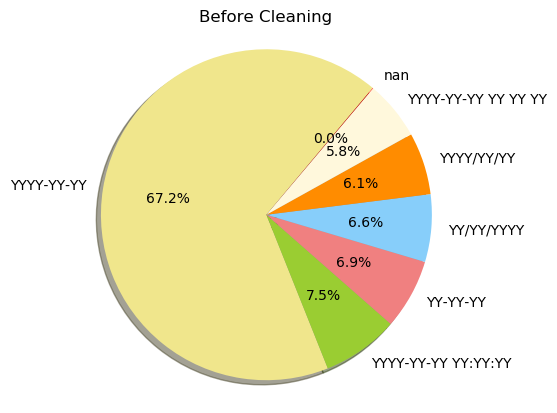

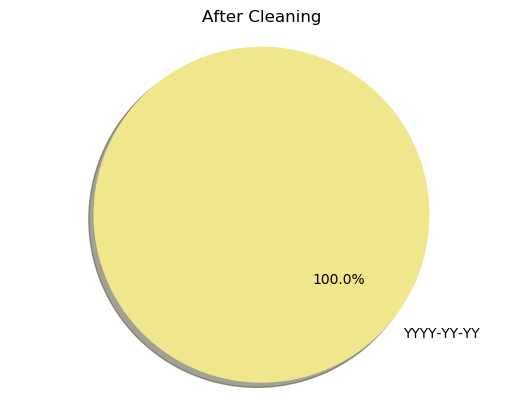

In [380]:
date_format_count_before = merged_before_transform["date_of_birth"].map(lambda x:re.sub(r'[0-9]','Y',str(x))).value_counts()
date_format_count_after = merged["date_of_birth"].map(lambda x:re.sub(r'[0-9]','Y',str(x))).value_counts()


labels = date_format_count_before.index
sizes = date_format_count_before.values
colors = ['khaki', 'yellowgreen', 'lightcoral', 'lightskyblue','darkorange','cornsilk','red']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=50)
 
plt.axis('equal')
plt.title('Before Cleaning')
plt.show()

labels = date_format_count_after.index
sizes = date_format_count_after.values
colors = ['khaki', 'yellowgreen', 'lightcoral', 'lightskyblue','darkorange','cornsilk','red']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('After Cleaning')
plt.axis('equal')
plt.show()